<a target="_blank" href="https://colab.research.google.com/github/Detroxsys/RP-2023-2/blob/main/Laboratorios/Lab04%20Personalidades%20por%20KMeans/Lab04_KMeans.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Laboratorio 04: K-means con Sklearn

## Agrupar usuarios Twitter de acuerdo a su personalidad con K-means

<p>Para la práctica se utilizará de entradas un conjunto de datos que se obtuvo de un proyecto propio, en el que se analiza rasgos de la personalidad de usuarios de Twitter. Se ha filtrado a 140 “famosos” del mundo en diferentes áreas: deporte, cantantes, actores, etc. Basado en una metodología de psicología conocida como “Ocean: The Big Five” se tiene como características de entrada:</p>

<ul>
    <li>usuario (el nombre en Twitter)</li>
    <li>“op” = Openness to experience – grado de apertura mental a nuevas experiencias, curiosidad, arte</li>
    <li>“co” = Conscientiousness – grado de orden, prolijidad, organización</li>
    <li>“ex” = Extraversion – grado de timidez, solitario o participación ante el grupo social</li>
    <li>“ag” = Agreeableness – grado de empatía con los demás, temperamento</li>
    <li>“ne” = Neuroticism, – grado de neuroticismo, nervioso, irritabilidad, seguridad en sí mismo.</li>
    <li>Wordcount – Cantidad promedio de palabras usadas en sus tweets</li>
    <li>Categoria – Actividad laboral del usuario (actor, cantante, etc.)</li>
</ul>
        
<p>Se utilizará el algoritmo K-means para que agrupe estos usuarios -no por su actividad laboral- si no, por sus similitudes en la personalidad. Sólo utilizaremos 3 columnas en este ejemplo, de modo que podamos ver en un gráfico tridimensional -y sus proyecciones a 2D- los grupos resultantes. Pero para casos reales, podemos utilizar todas las dimensiones que necesitemos. Una de las hipótesis que podríamos tener es: “Todos los cantantes tendrán personalidad parecida” (y así con cada rubro laboral). Pues veremos si lo probamos, o por el contrario, los grupos no están relacionados necesariamente con la actividad de estas Celebridades.</p>

In [1]:
#Importando las librerías que nos asistirán para ejecutar el algoritmo y graficar.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
 
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('fivethirtyeight')

In [2]:
#Importar el archivo csv y vemos los primeros 5 registros del archivo tabulados.
df = pd.read_csv("analisis.csv")
df.head(5)

,usuario,op,co,ex,ag,ne,wordcount,categoria
0,3gerardpique,34.297953,28.148819,41.948819,29.370315,9.841575,37.0945,7
1,aguerosergiokun,44.986842,20.525865,37.938947,24.279098,10.362406,78.7970,7
2,albertochicote,41.733854,13.745417,38.999896,34.645521,8.836979,49.2604,4
3,AlejandroSanz,40.377154,15.377462,52.337538,31.082154,5.032231,80.4538,2
4,alfredocasero1,36.664677,19.642258,48.530806,31.138871,7.305968,47.0645,4


In [3]:
#También podemos ver una tabla de información estadística que nos provee Pandas dataframe
df.describe()

,op,co,ex,ag,ne,wordcount,categoria
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,44.414591,22.977135,40.764428,22.918528,8.000098,98.715484,4.050000
std,8.425723,5.816851,7.185246,7.657122,3.039248,44.714071,2.658839
min,30.020465,7.852756,18.693542,9.305985,1.030213,5.020800,1.000000
25%,38.206484,19.740299,36.095722,17.050993,6.086144,66.218475,2.000000
50%,44.507091,22.466718,41.457492,21.384554,7.839722,94.711400,3.500000
75%,49.365923,26.091606,45.197769,28.678866,9.758189,119.707925,7.000000
max,71.696129,49.637863,59.824844,40.583162,23.978462,217.183200,9.000000


### Pregunta 1: (20 puntos)
¿Qué significa cada una de las estadísticas mostradas? Haga una pequeña explicación de cada una de ellas y utilice por cada una un valor como ejemplo para darle sentido a su explicación.¿Las estadísticas tienen sentido para la variable *categoría*?

<b>Respuesta 1:</b>

## Análisis Exploratorio

<p>El archivo contiene diferenciadas 9 categorías -actividades laborales- que son:</p>
<ol>
    <li>Actor/actriz</li>
    <li>Cantante</li>
    <li>Modelo</li>
    <li>Tv, series</li>
    <li>Radio</li>
    <li>Tecnología</li>
    <li>Deportes</li>
    <li>Politica</li>
    <li>Escritor</li>
</ol>



In [4]:
#Para conocer cuántos registros tenemos de cada una ponemos las siguientes lineas
#Primero mapeamos la columna para guardar la profesion de cada persona en el dataframe
mapping = {1:'Actor/actriz',
           2:'Cantante',
           3:'Modelo',
           4:'Tv, series',
           5:'Radio',
           6:'Tecnología',
           7:'Deportes',
           8:'Politica',
           9:'Escritor'}
inv_mapping = { label:number for label,number in mapping.items()}           
df['categoria_label'] =df['categoria'].map(mapping)


In [5]:
# Como vemos tenemos 34 cantantes, 27 actores, 17 deportistas, 16 políticos,etc
df['categoria_label'].value_counts()

Cantante        34
Actor/actriz    27
Tv, series      19
Deportes        17
Politica        16
Modelo           9
Tecnología       8
Escritor         6
Radio            4
Name: categoria_label, dtype: int64

array([[<AxesSubplot:title={'center':'op'}>,
        <AxesSubplot:title={'center':'co'}>,
        <AxesSubplot:title={'center':'ex'}>],
       [<AxesSubplot:title={'center':'ag'}>,
        <AxesSubplot:title={'center':'ne'}>,
        <AxesSubplot:title={'center':'wordcount'}>],
       [<AxesSubplot:title={'center':'categoria'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

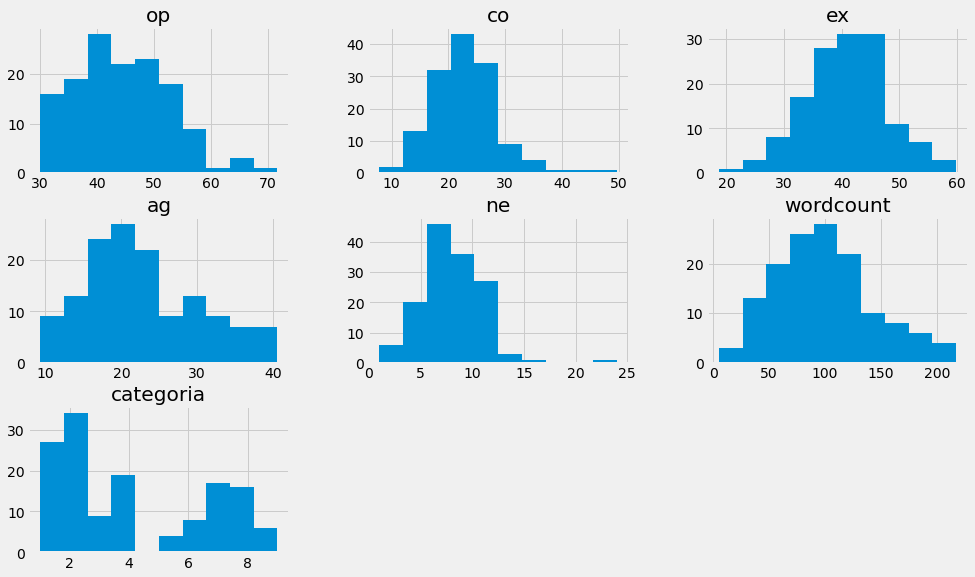

In [6]:
#Veremos graficamente nuestros datos para tener una idea de la dispersión de los mismos
df.hist(figsize=(15,9))

## K-means con 3 características 

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


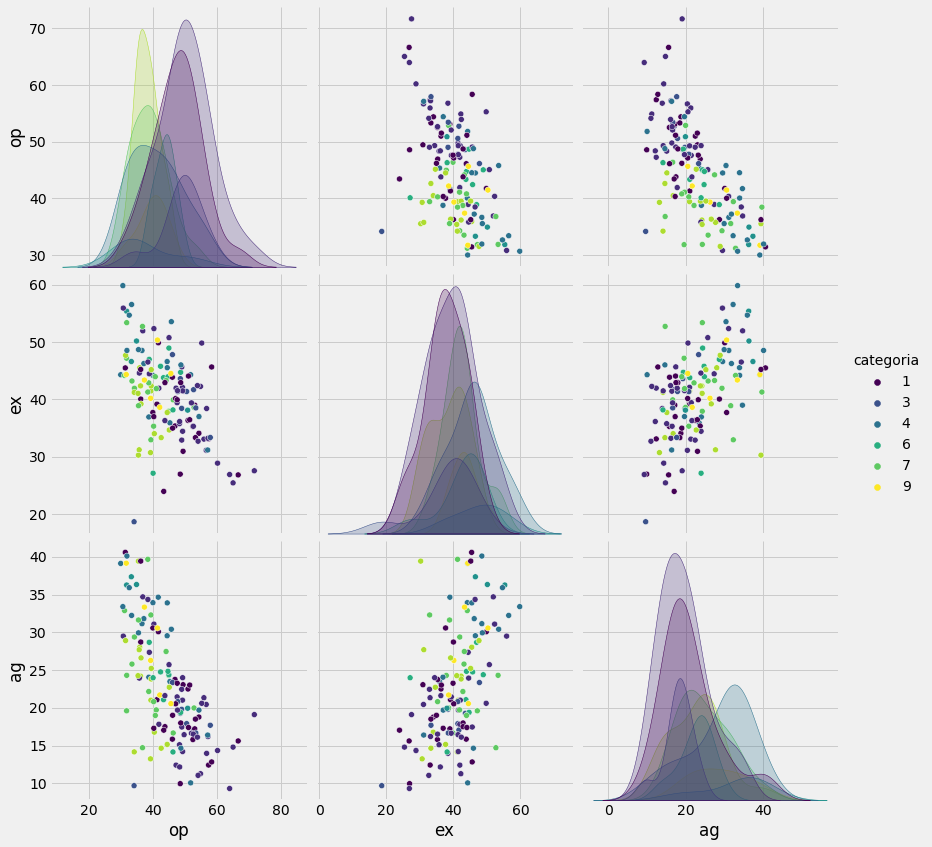

In [7]:
#En este caso seleccionamos 3 dimensiones: op, ex y ag 
#y las cruzamos para ver si nos dan alguna pista de su agrupación y la relación con sus categorías.
sns.pairplot(df.dropna(),palette='viridis', hue='categoria',size=4,vars=["op","ex","ag"],kind='scatter')
#Revisando la gráfica no pareciera que haya algún tipo de agrupación o correlación entre los usuarios y sus categorías

In [8]:
#Definimos la entrada
#Concretamos la estructura de datos que utilizaremos para alimentar el algoritmo.
#Sólo cargamos las columnas op, ex y ag en nuestra variable X.
X = np.array(df[["op","ex","ag"]])
y = np.array(df['categoria'])
X.shape

(140, 3)

<ipython-input-9-071aa75678b3>:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


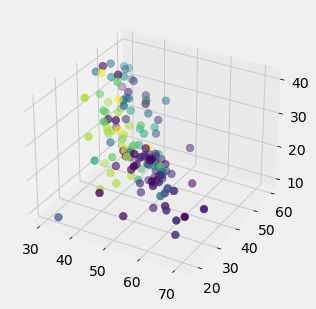

In [9]:
#Tenemos una gráfica en 3D con 9 colores representando las categorías.
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y,s=60)
#Veremos si con K-means, podemos “pintar” esta misma gráfica de otra manera, con clusters diferenciados.

Existen diferentes formas de medir que tan bueno es el rendimiento de un modelo de KMeans. Una librería que podría ser de utilidad es [Yellowbrick](https://www.scikit-yb.org/en/latest/). 

Particularmente aquí se muestra el uso de Elbow Method y Silhouette para observar el desempeño de KMeans. Los detalles se pueden consultar [aquí](https://stackabuse.com/k-means-elbow-method-and-silhouette-analysis-with-yellowbrick-and-scikit-learn/)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: F

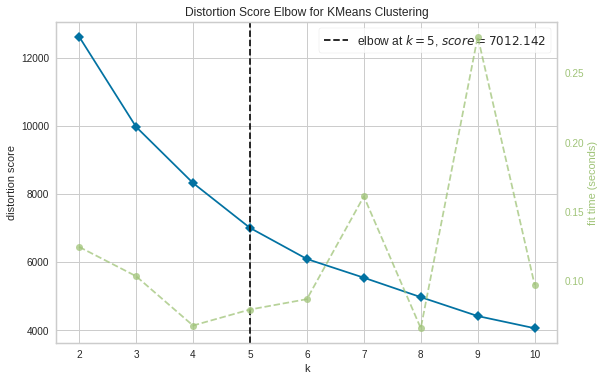

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
model = KMeans(random_state=42)

elb_visualizer = KElbowVisualizer(model, k=(2,11))
elb_visualizer.fit(X)    
elb_visualizer.show()

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


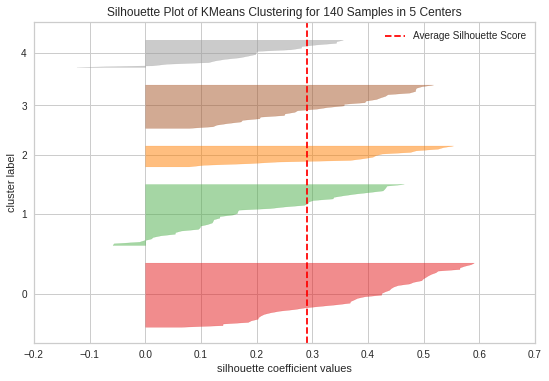

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 140 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [11]:
model_5clust = KMeans(n_clusters = 5, random_state=42)

sil_visualizer = SilhouetteVisualizer(model_5clust)
sil_visualizer.fit(X)    
sil_visualizer.show()

En este caso el *método del codo* nos indice que 5 clusters podrían funcionar para realizar los clusters de acuerdo con el score de distorción. No obstante con el *método de la silueta* observamos que el score para cada cluster no es particularmente bueno (es deseable que sean cercanos a 1) aunque en general notamos que la población queda bien distribuida entre los clusters. 

### Pregunta 2 (20 puntos)
Realmente la curva es bastante “suave”. Se considera a 5 como un buen número para K. Existen otras métricas que pueden utilizarse para evaluar el desempeño de KMeans, el default de Yellowbrick es *distortion* que calcula la suma de los cuadrados de las distancias de cada observación a su centro. Pero también se pueden usar métricas como *silhouette* y *calinski_harabaz* cuyos detalles puedes consultar [aquí](https://www.kaggle.com/code/kautumn06/yellowbrick-clustering-evaluation-examples)

<b>Pregunta 2: (20 puntos)</b> Realiza de nuevo el análisis por método del codo con las otras dos métricas. Finalmente, según su criterio, ¿que número de clusters tomaría y por qué?

<b>Respuesta 2:</b>

### Construyendo el modelo

In [32]:
#Ejecutamos K-Means
#Ejecutamos el algoritmo para 5 clusters y obtenemos las etiquetas y los centroids.
kmeans = KMeans(n_clusters=5, random_state=42).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[50.29293117 40.88830576 17.44525734]
 [39.38661285 42.15968677 25.09420592]
 [59.42730336 30.78901593 16.13449193]
 [35.66710486 49.09548071 33.93645793]
 [43.84963683 32.25843939 18.80892339]]


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<ipython-input-13-015df12f9fd6>:14: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


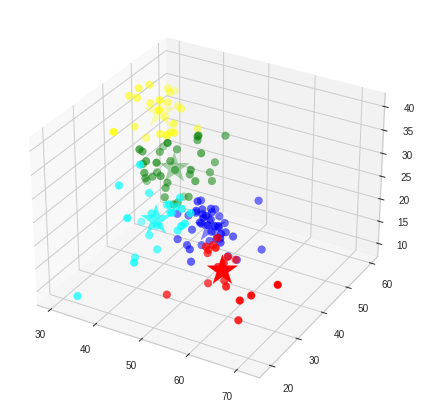

In [13]:
#Ahora se puede ver esto en una gráfica 3D con colores para los grupos y veremos si se diferencian:
# (las estrellas marcan el centro de cada cluster)

# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores = ['red','green','blue','cyan','yellow']
kcluster_label = []
for row in labels:
    kcluster_label.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=kcluster_label,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

#Podemos ver que el Algoritmo de K-Means con K=5 ha agrupado a los 140 usuarios Twitter por su personalidad,
# teniendo en cuenta las 3 dimensiones que utilizamos: Openess, Extraversion y Agreeablenes. 
#Pareciera que no hay necesariamente una relación en los grupos con sus actividades de Celebrity.

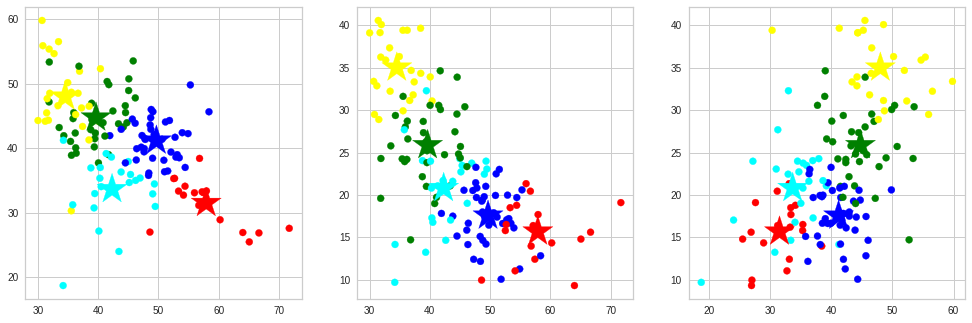

In [14]:
#Se generan 3 gráficas en 2 dimensiones con las proyecciones a partir de nuestra gráfica 3D 
# para que nos ayude a visualizar los grupos y su clasificación

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter( df['op'], df['ex'], c=kcluster_label)
ax[0].scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
ax[1].scatter( df['op'], df['ag'], c=kcluster_label)
ax[1].scatter(C[:, 0], C[:, 2], marker='*', c=colores, s=1000)
ax[2].scatter(df['ex'], df['ag'], c=kcluster_label)
ax[2].scatter(C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

#Se puede observar que están bastante bien diferenciados los grupos.


In [33]:
#Ahora bien, podemos ver cada uno de los clusters cuántos usuarios tiene:
cluster_profesiones = df[['usuario', 'categoria_label']] 
cluster_profesiones['label']=labels

cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=cluster_profesiones.groupby('label').size()
cantidadGrupo

<ipython-input-33-41b98237fc74>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_profesiones['label']=labels


,color,cantidad
0,red,18
1,green,35
2,blue,40
3,cyan,23
4,yellow,24


In [35]:
#También podemos ver las profesiones que componen a cada cluster. 
cluster_profesiones[cluster_profesiones['label']==0]['categoria_label'].value_counts()
#Por ejemplo el cluster 0 (coloreado con rojo) esta compuesto mayormente
#por cantantes y actrices. 

Cantante        10
Actor/actriz     6
Tv, series       1
Modelo           1
Name: categoria_label, dtype: int64

In [17]:
#Buscaremos los usuarios que están más cerca a los centroids de cada grupo que podríamos decir que
# tienen los rasgos de personalidad característicos que representan a cada cluster:

#vemos el representante del grupo, el usuario cercano a su centroid
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
closest

#El resultado de la consulta muestra la posicion en el array de usuarios

array([ 82, 107,  21,  91,  35])

In [37]:
#En este caso podemos ver que en los centros tenemos una modelo,
# un político, presentadora de Tv, locutor de Radio y un deportista.
users=df['usuario'].values
for row in closest:
    print(users[row])

JudgeJudy
Pablo_Iglesias_
carmenelectra
kobebryant
DaniMateoAgain


### Clasificar nuevas muestras

In [39]:
#Finalmente podemos agrupar y etiquetar nuevos usuarios twitter con sus características y clasificarlos.
X_new = np.array([[45.92,57.74,15.66]]) #davidguetta

new_labels = kmeans.predict(X_new)
print(new_labels)

#Vemos el ejemplo con el usuario de David Guetta y nos devuelve que pertenece al grupo 0 (rojo).

[0]


## Conclusiones

<p>El algoritmo de Clustering K-means es uno de los más usados para encontrar grupos ocultos, o sospechados en teoría sobre un conjunto de datos no etiquetado. Esto puede servir para confirmar -o desterrar- alguna teoría que teníamos asumida de nuestros datos o negocio. Y también puede ayudarnos a descubrir relaciones asombrosas entre conjuntos de datos, que de manera manual, no hubiéramos reconocido. Una vez que el algoritmo ha ejecutado y obtenido las etiquetas, será fácil clasificar nuevos valores o muestras entre los grupos obtenidos.</p>

<p>Algunos casos de uso son:</p>
<ul>
    <li>Segmentación por Comportamiento: relacionar el carrito de compras de un usuario, sus tiempos de acción e información del perfil.</li>
    <li>Categorización de Inventario: agrupar productos por actividad en sus ventas</li>
    <li>Detectar anomalías o actividades sospechosas: según el comportamiento en una web reconocer un troll -o un bot- de un usuario normal</li>
</ul>

<p>Atención: Puede haber casos en los que <b>no existan grupos naturales</b>, o clusters que contengan una verdadera razón de ser. Si bien K-means siempre nos brindará “k clusters”, quedará en nuestro criterio reconocer la utilidad de los mismos o bien revisar nuestras features y descartar las que no sirven o conseguir nuevas. También tener en cuenta que en este ejemplo estamos utilizando como medida de similitud entre features la distancia Euclideana pero podemos utilizar otras diversas funciones que podrían arrojar mejores resultados (como Manhattan, Lavenshtein, Mahalanobis, etc).</p>


### Pregunta 3: (20 puntos) 

Repita el análisis anterior de K-means anterior pero usando las 5 características **op,co,	ex,	ag, ne**. 

### Pregunta 4: (40 puntos)
Prueba implementar K-Means con 3 y 5 características utilizando otras dos medidas de similitud de las mencionadas anteriormente. ¿Los modelos mejoran con alguna de ellas?. Emita sus comentarios al respecto. 
`Sklearn` no permite utilizar otras métricas en la versión disponible, pero se puede realizar la implementación con otras bibliotecas como [`pyclustering`](https://pyclustering.github.io/docs/0.8.2/html/da/d22/classpyclustering_1_1cluster_1_1kmeans_1_1kmeans.html). [Aquí](https://www.kaggle.com/code/arushchillar/kmeans-clustering-using-different-distance-metrics) puedes consultar un ejemplo de la implementación. 
